# Outfit Compatibility Prediction

Multi-task approach

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
# sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
# import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"

train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"
train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

model_type = "rnn" #"set-transformer"
include_text = True

In [4]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
with open(os.path.join(base_dir, outfit_file), 'r') as fr:
    pv_outfits = json.load(fr)

print(f"Total {len(train_pos)}, {len(valid_pos)}, {len(test_pos)} outfits in train, validation and test split, respectively")

Total 53306, 5000, 10000 outfits in train, validation and test split, respectively


In [5]:
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])

with open(os.path.join(train_dir, valid_file), 'r') as fr:
    valid_X, valid_y = [], []
    for line in fr:
        elems = line.strip().split()
        valid_y.append(elems[0])
        valid_X.append(elems[1:])

with open(os.path.join(train_dir, test_file), 'r') as fr:
    test_X, test_y = [], []
    for line in fr:
        elems = line.strip().split()
        test_y.append(elems[0])
        test_X.append(elems[1:])

print(f"Total {len(train_X)}, {len(valid_X)}, {len(test_X)} examples in train, validation and test split, respectively")

Total 106612, 10000, 20000 examples in train, validation and test split, respectively


In [6]:
item_dict = {}
for ii, outfit in enumerate(train_pos):
    items = outfit['items']
    mapped = train_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(valid_pos):
    items = outfit['items']
    mapped = valid_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

for ii, outfit in enumerate(test_pos):
    items = outfit['items']
    mapped = test_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
print(len(item_dict))

284767
311548
365054


In [7]:
tf.__version__

'2.2.0'

In [8]:
from rnn import build_multitask_rnn, build_multitask_rnn2
from graph import build_multitask_gat
from build_model import build_multitask_set_transformer

In [9]:
model_type = "rnn" # "set-transformer", "rnn"
include_text = True
contrastive_loss = False
use_graphsage = False
batch_size = 32
max_seq_len = 8
if use_graphsage:
    image_embedding_dim = 50
    image_embedding_file = os.path.join(embed_dir, "graphsage_dict2_polyvore.pkl")
else:
    image_embedding_dim = 1280
    image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
batch_cardinality = 140  # maximum number of items to be considered in a batch

In [10]:
if model_type == "rnn":
    model = build_multitask_rnn(max_seq_len, 
                                image_embedding_dim,
                                num_classes=2,
                                num_layers=2,
                                d_model=512,
                                rnn="bilstm",
                                final_activation="sigmoid",
                                merge_activation="tanh", 
                                include_text=include_text,
                                num_classes2=batch_cardinality,
                                )
elif model_type == "rnn2":
    model = build_multitask_rnn2(max_seq_len, 
                                 image_embedding_dim,
                                 num_classes=2,
                                 num_layers=1,
                                 d_model=512,
                                 rnn="bilstm",
                                 final_activation="sigmoid",
                                 merge_activation="tanh",
                                 use_contrastive_loss=contrastive_loss,
                                )

elif model_type == "transformer":
    model = build_multitask_transformer(max_seq_len, 
                                         image_embedding_dim,
                                         num_layers=1,
                                         d_model=64,
                                         num_heads=1,
                                         dff=32,
                                         rate=0.0,
                                         include_text=include_text,
                                         inp_dim2=768,
                                         num_classes=2,
                                         lstm_dim=32,
                                         embedding_activation="linear",
                                         lstm_activation="linear",
                                         final_activation="sigmoid"
                                        )
elif model_type == "set-transformer":
    model = build_multitask_set_transformer(max_seq_len, 
                                            image_embedding_dim, 
                                            num_layers=3,
                                            d_model=256,
                                            num_heads=1,
                                            dff=32,
                                            num_classes=2,
                                            lstm_dim=32,
                                            include_text=include_text,
                                            inp_dim2=768,
                                            first_activation="tanh",
                                            embedding_activation="tanh",
                                            lstm_activation="tanh",
                                            final_activation="sigmoid",
                                            add_contrastive_loss=contrastive_loss,
                                           )
elif model_type == "gat":
    model = build_multitask_gat(max_seq_len, 
                                image_embedding_dim,
                                num_classes=2,
                                num_layers=1,
                                num_heads=8,
                                hidden_units=100,
                                final_activation="sigmoid",
                                merge_activation="tanh", 
                                include_text=include_text)
    
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8, 1280)]    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 8, 768)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum (TensorFlowOpLa [(None, 8)]          0           input_7[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sum_1 (TensorFlowOp [(None, 8)]          0           input_8[0][0]                    
________________________________________________________________________________________________

In [11]:
all_item_categories = set([pv_items[item]['category_id'] for item in pv_items])
len(all_item_categories)

153

In [12]:
label_renum_dict = {}
for ii, k in enumerate(all_item_categories):
    label_renum_dict[k] = ii

In [13]:
# keras.utils.plot_model(model)
from data_process import CustomDataGen
train_gen = CustomDataGen(train_X, train_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          return_item_categories=True,
                          return_negative_samples=contrastive_loss,
                          number_negative_samples=8,
                          label_dict=label_renum_dict,
                          number_items_in_batch=batch_cardinality-2,
                         )

valid_gen = CustomDataGen(valid_X, valid_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          return_item_categories=True,
                          return_negative_samples=contrastive_loss,
                          number_negative_samples=8,
                          label_dict=label_renum_dict,
                          number_items_in_batch=batch_cardinality-2,
                         )

In [14]:
for ii in range(10):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], [y.shape for y in targs])

[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]
[(32, 8, 1280), (32, 8, 768)] [(32,), (32, 8)]


In [15]:
targs[1]

array([[ -1,  -1,  -1,  37, 105,  14,  64, 139],
       [ -1,  -1,  -1,  -1, 102,  70, 134, 139],
       [ -1,  -1,  68, 138, 138,  30,  95, 139],
       [ -1,  -1,  -1,  -1, 138,  57, 138, 139],
       [ -1,  -1,  62,  73, 138, 112, 108, 139],
       [ -1,  90, 117, 111,  93,  59, 118, 139],
       [ -1,  54,  99,  35, 104,  47,  49, 139],
       [ -1,  -1,  11,  50,  74,   4,  41, 139],
       [ -1,  -1,  65,  22, 138, 138,  43, 139],
       [ -1, 115, 123,  71,  94,  19, 138, 139],
       [ -1,  -1,  -1,  -1,  -1,  55, 137, 139],
       [ -1,  -1,  -1, 100,  92,   1,  31, 139],
       [ -1,  -1,  17,  48,  21, 132,  83, 139],
       [ -1,  -1,  69,  96,   7,  63,  27, 139],
       [ -1,  -1,  -1,  -1,  18,  23,   0, 139],
       [ 81, 106, 138,  89, 138, 138,   5, 139],
       [ -1,  -1,  -1,  13,  33, 138,   6, 139],
       [ -1,  -1,   9, 138, 131, 138, 133, 139],
       [ -1,  -1, 138,  20,  75,  87, 138, 139],
       [ -1,  -1,  -1, 128, 138, 129, 119, 139],
       [ -1,  -1,  -

In [16]:
def sparse_crossentropy_masked(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.not_equal(y_true, -1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.not_equal(y_true, -1))
    return K.mean(K.sparse_categorical_crossentropy(y_true_masked, y_pred_masked))


def contrastive_masked(y_true, y_pred):
    loss_mask = tf.not_equal(y_true, -1)
    y_pred_masked = tf.boolean_mask(y_pred, loss_mask, name='contrastive')
    return K.mean(y_pred_masked)


In [17]:
# yhat = model(inps)
# print([y.shape for y in yhat])
# print([y.shape for y in targs])
# scce = tf.keras.losses.SparseCategoricalCrossentropy()
# scce(y[1], yh2).numpy()
# sparse_crossentropy_masked(y[1], yh2).numpy()
# contrastive_masked(targs[2], yhat[2])

In [19]:
learning_rate = 1.0e-05
epochs = 100
patience = 10
model_name1 = "item_classification"
model_name2 = "compatibility"
model_name3 = "tf_op_layer_contrastive"
opt = keras.optimizers.Adam(learning_rate=learning_rate)
if contrastive_loss:
    loss_dict = {model_name2: tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'), 
                 model_name1: sparse_crossentropy_masked,
                 model_name3: "mse", #"mse", contrastive_masked
                }
    weight_dict = {model_name1: 1.0, 
                   model_name2: 1.0, 
                   model_name3: 1.0e-02
                  }
    metric_dict = {model_name1: 'accuracy', 
                   model_name2: tf.keras.metrics.AUC(), 
                   model_name3: "mse"
                  }
else:
    loss_dict = {model_name2: tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'), 
                 model_name1: sparse_crossentropy_masked,
                }
    weight_dict = {model_name1: 1.0, 
                   model_name2: 1.0, 
                  }
    metric_dict = {model_name1: 'accuracy', 
                   model_name2: tf.keras.metrics.AUC(), 
                  }
    
model.compile(loss=loss_dict,
              loss_weights=weight_dict,
              optimizer=opt,
              metrics=metric_dict)

callback = EarlyStopping(
                        monitor="val_compatibility_loss", # "val_loss", "val_compatibility_loss"
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=1e-06)

tic = time.time()
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=valid_gen,
                    validation_batch_size=32,
                    validation_freq=1,
                    callbacks=[callback],
                    verbose=1)
time.time() - tic

Epoch 1/100
3332/3332 [==============================] - 367s 110ms/step - loss: 3.1511 - compatibility_loss: 0.6950 - item_classification_loss: 2.4561 - compatibility_auc_1: 0.4995 - item_classification_accuracy: 0.2175 - val_loss: 3.1175 - val_compatibility_loss: 0.6929 - val_item_classification_loss: 2.4245 - val_compatibility_auc_1: 0.5207 - val_item_classification_accuracy: 0.2237
Epoch 2/100
3332/3332 [==============================] - 358s 107ms/step - loss: 3.1070 - compatibility_loss: 0.6935 - item_classification_loss: 2.4136 - compatibility_auc_1: 0.5085 - item_classification_accuracy: 0.2235 - val_loss: 3.1145 - val_compatibility_loss: 0.6912 - val_item_classification_loss: 2.4233 - val_compatibility_auc_1: 0.5462 - val_item_classification_accuracy: 0.2233
Epoch 3/100
3332/3332 [==============================] - 357s 107ms/step - loss: 3.0942 - compatibility_loss: 0.6816 - item_classification_loss: 2.4127 - compatibility_auc_1: 0.5792 - item_classification_accuracy: 0.2235 -

3332/3332 [==============================] - 358s 107ms/step - loss: 2.8507 - compatibility_loss: 0.4387 - item_classification_loss: 2.4120 - compatibility_auc_1: 0.8754 - item_classification_accuracy: 0.2234 - val_loss: 2.9895 - val_compatibility_loss: 0.5669 - val_item_classification_loss: 2.4226 - val_compatibility_auc_1: 0.8031 - val_item_classification_accuracy: 0.2236
Epoch 23/100
3332/3332 [==============================] - 357s 107ms/step - loss: 2.8425 - compatibility_loss: 0.4299 - item_classification_loss: 2.4126 - compatibility_auc_1: 0.8806 - item_classification_accuracy: 0.2235 - val_loss: 2.9960 - val_compatibility_loss: 0.5733 - val_item_classification_loss: 2.4227 - val_compatibility_auc_1: 0.8030 - val_item_classification_accuracy: 0.2236
Epoch 24/100
3332/3332 [==============================] - 358s 107ms/step - loss: 2.8316 - compatibility_loss: 0.4194 - item_classification_loss: 2.4122 - compatibility_auc_1: 0.8870 - item_classification_accuracy: 0.2235 - val_loss:

10044.929625034332

In [23]:
print("DOne")

DOne


In [21]:
def plot_results(history, auc_str = 'auc'):
    f, axs = plt.subplots(2,2,figsize=(15,6))
    max_val_auc = max(history.history[f'val_compatibility_{auc_str}'])
    f.suptitle(f'Performance of a {model_type} model (Max. AUC = {max_val_auc:.4})', fontsize=16)
    plt.subplot(221)
    plt.plot(history.history['compatibility_loss'], label='train-compatibility-loss')
    plt.plot(history.history['val_compatibility_loss'], label='validation-loss')
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['item_classification_loss'], label='train-classification-loss')
    plt.plot(history.history['val_item_classification_loss'], label='validation-loss')
    plt.legend()

    plt.subplot(223)
    plt.plot(history.history[f'compatibility_{auc_str}'], label='train-AUC')
    plt.plot(history.history[f'val_compatibility_{auc_str}'], label='validation-AUC')
    plt.legend()

    plt.subplot(224)
    plt.plot(history.history['item_classification_accuracy'], label='train-accuracy')
    plt.plot(history.history['val_item_classification_accuracy'], label='validation-accuracy')
    plt.legend()    

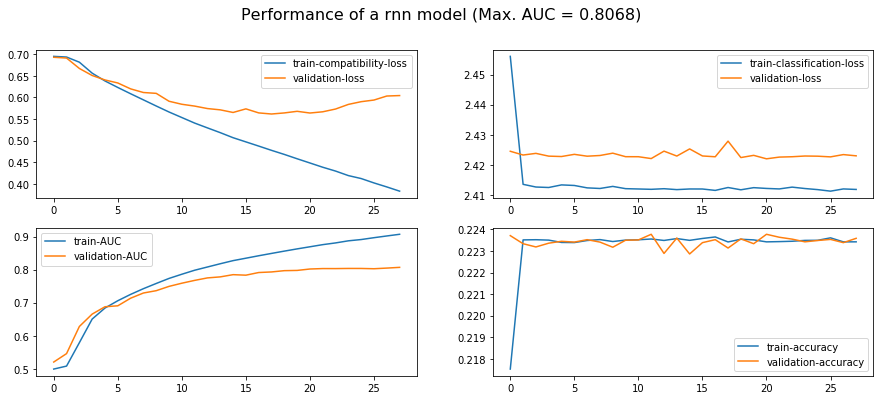

In [22]:
plot_results(history, auc_str = 'auc_1')

In [ ]:
plot_results(history, auc_str = 'auc')

In [ ]:
f, axs = plt.subplots(2,2,figsize=(15,6))
max_val_auc = max(history.history['val_compatibility_auc'])
f.suptitle(f'Performance of a {model_type} model (Max. AUC = {max_val_auc})', fontsize=16)
plt.subplot(221)
plt.plot(history.history['compatibility_loss'], label='train-compatibility-loss')
plt.plot(history.history['val_compatibility_loss'], label='validation-loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['item_classification_loss'], label='train-classification-loss')
plt.plot(history.history['val_item_classification_loss'], label='validation-loss')
plt.legend()

plt.subplot(223)
plt.plot(history.history['compatibility_auc'], label='train-AUC')
plt.plot(history.history['val_compatibility_auc'], label='validation-AUC')
plt.legend()

plt.subplot(224)
plt.plot(history.history['item_classification_accuracy'], label='train-accuracy')
plt.plot(history.history['val_item_classification_accuracy'], label='validation-accuracy')
plt.legend()

In [ ]:
f, axs = plt.subplots(2,2,figsize=(15,6))
f.suptitle(f'Performance of a {model_type} model', fontsize=16)
plt.subplot(221)
plt.plot(history.history['compatibility_loss'], label='train-compatibility-loss')
plt.plot(history.history['val_compatibility_loss'], label='validation-loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['item_classification_loss'], label='train-classification-loss')
plt.plot(history.history['val_item_classification_loss'], label='validation-loss')
plt.legend()

plt.subplot(223)
plt.plot(history.history['compatibility_auc'], label='train-AUC')
plt.plot(history.history['val_compatibility_auc'], label='validation-AUC')
plt.legend()

plt.subplot(224)
plt.plot(history.history['item_classification_accuracy'], label='train-accuracy')
plt.plot(history.history['val_item_classification_accuracy'], label='validation-accuracy')
plt.legend()

In [23]:
test_gen = CustomDataGen(test_X, test_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=True,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          return_item_categories=True,
                          return_negative_samples=contrastive_loss,
                          number_negative_samples=8,
                          label_dict=label_renum_dict,
                          number_items_in_batch=batch_cardinality-2,
                         )

In [29]:
def get_accuracy_auc(data_gen):
    m = tf.keras.metrics.BinaryAccuracy()
    m2 = tf.keras.metrics.AUC()
    acc_list = []
    pbar = tqdm(range(len(data_gen)))
    ys, yhats = [], []
    for ii in pbar:
        x, y = data_gen[ii]  # batch size
        yhat = model(x)
        m.update_state(y[0], yhat[0])
        batch_acc = m.result().numpy()
        acc_list.append(batch_acc)
        pbar.set_description("Batch accuracy %g" % batch_acc)
        ys.append(y[0])
        yhats.append(yhat[0])
    print(f"Average Accuracy: {np.mean(acc_list):.4}")
    big_y = np.concatenate(ys, axis=0)
    big_yh = np.concatenate(yhats, axis=0)
    m2.update_state(big_y, big_yh)
    auc = m2.result().numpy()
    print(f"AUC: {auc:.4}")


In [30]:
get_accuracy_auc(test_gen)

Batch accuracy 0.72495: 100%|██████████| 625/625 [01:18<00:00,  7.98it/s] 


Average Accuracy: 0.727
AUC: 0.7978


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

In [17]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)

172032/168052 [==============================] - 0s 1us/step
      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]


In [18]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

In [20]:
# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape:		 (5429, 2)
Node features shape: (2708, 1433)


In [21]:
train_indices.shape, train_labels.shape

((1354,), (1354,))

In [15]:
items_by_category, item2cat = {}, {}
for item, desc in pv_items.items():
    cat = desc['category_id']
    item2cat[item] = cat
    if cat in items_by_category:
        items_by_category[cat].append(item)
    else:
        items_by_category[cat] = [item]

In [19]:
from rnn import build_multitask_rnn2
model = build_multitask_rnn2(max_seq_len, 
                            image_embedding_dim,
                            num_classes=2,
                            num_layers=1,
                            d_model=512,
                            rnn="bilstm",
                            final_activation="sigmoid",
                            merge_activation="tanh", 
                            )
model.summary()

(None, 8)
Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8, 1280)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 8, 768)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 8, 8, 768)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 8, 8, 1280)] 0                                            
______________________________________________________________________________________

In [52]:
from build_model import MultiTaskSetTransformer

model = MultiTaskSetTransformer(
                                 num_layers=1,
                                 d_model=64,
                                 num_heads=1,
                                 dff=32,
                                 rate=0.0,
                                 include_text=include_text,
                                 inp_dim2=768,
                                 num_classes=2,
                                 lstm_dim=32,
                                 embedding_activation="linear",
                                 lstm_activation="linear",
                                 final_activation="sigmoid"
                                )


In [53]:
ys = model(x)
ys[0].shape, ys[1].shape, ys[2].shape

NameError: name 'x' is not defined

In [64]:
from rnn import MultiTaskRNN

model = MultiTaskRNN()
yhat = model(inps)
[yh.shape for yh in yhat]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[TensorShape([32, 1]),
 TensorShape([32, 8, 153]),
 TensorShape([32, 8]),
 TensorShape([32, 8])]

In [72]:
msk = targs[1] != -1
msk = msk.astype('float64')
msk

array([[0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 

In [65]:
yhat[3]

<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [

In [58]:
def loss_function(outputs, labels):
    compatibility_output, class_probs, contrastive_loss, istarget = outputs
    compatibility_label, item_categories, contrastive_labels = labels
    loss_1 = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, name="binary_crossentropy"
    )(compatibility_label, compatibility_output)

    loss_2 = sparse_crossentropy_masked(item_categories, class_probs)
    loss_3 = tf.reduce_sum(contrastive_loss * istarget) / tf.reduce_sum(istarget)

    loss = loss_1 + loss_2 + loss_3
#     reg_loss = tf.compat.v1.losses.get_regularization_loss()
    # reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
    # loss += sum(reg_losses)
#     loss += reg_loss
    return loss

In [59]:
loss_function(yhat, targs)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [44]:
tf.keras.losses.BinaryCrossentropy(
        from_logits=False, name="binary_crossentropy"
    )(targs[0], yhat[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.68840075>

In [45]:
sparse_crossentropy_masked(targs[1], yhat[1])

<tf.Tensor: shape=(), dtype=float32, numpy=5.0698247>

In [48]:
tf.reduce_sum(yhat[2] * yhat[3])# / tf.reduce_sum(yhat[3])

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

## Python is crazy!!

In [20]:
a = {'x1': [1, 2, 3], 'x2': [4, 5, 6]}
a

{'x1': [1, 2, 3], 'x2': [4, 5, 6]}

In [21]:
b = a['x1'].copy()
b.remove(2)
a

{'x1': [1, 2, 3], 'x2': [4, 5, 6]}